In [ ]:
# ANALIZA MEDICINSKIH SLIK 2019-2020
# SEMINARSKA NALOGA: Zaznavanje sprememb lezij v MR slikah glave z nevronskimi mrežami
# MODEL: U-net
# IZHOD MODELA: razlika mask M1-M2

In [ ]:
# Izpis nameščenih paketov.
# !pip3 freeze

In [ ]:
# 1. INICIALIZACIJA

In [1]:
# Nalaganje knjižnic

import os
import sys
import random
import warnings

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from scipy.stats import ttest_rel, ttest_ind, wilcoxon, mannwhitneyu

import keras
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose, Conv3D, Conv3DTranspose
from keras.layers.pooling import MaxPooling2D, MaxPooling3D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

import amslib_seminar
import importlib
importlib.reload(amslib_seminar)
from amslib_seminar import load_mri_brain_data, load_mri_brain_data_classifications

Using TensorFlow backend.


In [2]:
# Določitev parametrov.

# Nastavitev željene velikosti slik za učenje U-net modelov.
IMG_WIDTH=192
IMG_HEIGHT=192
IMG_DEPTH=1
NO_SLICES=1

# Določitev možnih modalitet.
# OPOMBA: v kolikor podamo le eno modaliteto, moramo dati na koncu vejico, sicer prevajalnik prepozna spremenljivko kot skalar in ne kot seznam.
MODALITIES1=('flair_02',) # Modalitete za izgradnjo maske lezij M2
MODALITIES2=('flair_01','flair_02') # Modalitete za izgradnjo maske sprememb lezij M2-M1.
MODALITIES=MODALITIES2

# Določitev tipa podatkov.
DTYPE='float16'

# Določitev mape z modeli.
MODELS_PATH='models'

# Določitev imena datoteke s shranjenim modelom.
# OPOMBA: pomen posameznih vrednosti:
# - sbmt/ams: model ustvarjen za Seminar iz Biomedicinske tehnike ali za seminar Analiza medicinskih slik.
# - unet1/unet2/seq: arhitektura modela.
# - 1/3/16/32/64/128/192: število aksialnih rezin. OPOMBA: na koncu ohranjeni le modeli za manipulacijo slik z eno rezino (2D slike).
# - 192-192/128-128/64-64/32-32/16-16: dimenzije aksialnih rezin.
# - 1/2/3/4/5: število modalitet.
# - f16/f32/f64: podatkovni tip s plavajočo vejico.
# - j/c: model ustvarjen na PC-ju v okolju Jupyterlab ali na spletu v okolju Google Colab.
MODEL_NAME1='ams-unet1-1-192-192-1-f16-j.h5'
MODEL_NAME2='ams-unet2-1-192-192-2-f16-j.h5'
MODEL_NAME=MODEL_NAME2

# Določitev mejne spremembe skupnega volumna lezij za aktivno MS.
DV_THRESHOLD=0
# OPOMBA: prag arbitrarno določen glede na razporeditev sprememb volumnov v beležki Seminar_referenca.

# Določitev mejnih sprememb skupnega volumna lezij za aktivno MS za posamezne izbire rezin.
DV_THRESHOLD_2D=0 # v cm**2

# Določitev semena za generacijo vedno istega zaporedja psevdonaključnih števil.
SEED = 42

# Določitev deleža testnih podatkov.
TEST_DATA_FRACTION = 0.3

# Določitev števila razredov pri razvrščanju.
NUM_CLASSES = 2 # binarno razvrščanje

# Določitev hiperparametrov pri učenju.
BATCH_SIZE = 32
NUM_EPOCHS = 100
LEARNING_RATE = 1e-3

# Nastavitev praga razvrščanja.
THRESHOLD = 0.5

In [ ]:
# 2. PRIPRAVA PODATKOV

In [3]:
# Definicija funkcije za izris vzorca učnih podatkov.

def viewImagesInput2d(X_train,Y0_train,Y1_train,Y01_train,MODALITIES):

    # Check if training data looks all right
    ix = random.randint(0, X_train.shape[0]-1)
    # OPOMBA: v funkcijo dodana vrednost -1, sicer lahko pri izbiranju slik z indeksom za 1 prekoračimo nabor možnih slik.
    _, _, num_modalities = X_train[ix].shape

    titles = [m.upper() + ' slika' for m in MODALITIES] + ['Maska 1','Maska 2','Referenčna razgradnja']
    f, ax = plt.subplots(1, num_modalities+3, sharex=True, sharey=True, figsize=(20, 5))
    for i in range(num_modalities):
        ax[i].imshow(X_train[ix][:,:,i].astype('float32'), cmap='gray')
        ax[i].set_title(titles[i])
        ax[i].axis('off')
    ax[-3].imshow(np.squeeze(Y0_train[ix][:,:].astype('float32')))
    ax[-3].set_title(titles[-3])
    ax[-2].imshow(np.squeeze(Y1_train[ix][:,:].astype('float32')))
    ax[-2].set_title(titles[-2])
    ax[-1].imshow(np.squeeze(Y01_train[ix][:,:].astype('float32')))
    ax[-1].set_title(titles[-1])
    # OPOMBA: pretvorbo v format float32 pri prikazovanju opravimo, ker imshow ne podpira formata float16.

In [4]:
# Nalaganje referenčnih podatkov o klasifikacijah.
Y=load_mri_brain_data_classifications(dV_threshold=DV_THRESHOLD,dtype=DTYPE)

# Izpis lastnosti podatkov.
print('Velikost izhodnih podatkov:',Y.shape)
print('Možne vrednosti izhodnih podatkov',np.unique(Y))
print('Tip izhodnih podatkov:',Y.dtype)
MSn=np.count_nonzero(Y[:,0])
MSa=np.count_nonzero(Y[:,1])
print('Število pacientov z neaktivno MS: {:d}'.format(MSn))
print('Število pacientov z aktivno MS: {:d}'.format(MSa))

100%|████████████████████████████████████████████████████████████████████████████████| 162/162 [00:13<00:00, 11.81it/s]


Velikost izhodnih podatkov: (162, 2)
Možne vrednosti izhodnih podatkov [0. 1.]
Tip izhodnih podatkov: float16
Število pacientov z neaktivno MS: 73
Število pacientov z aktivno MS: 89


In [5]:
# Nalaganje vhodnih podatkov pri učenju (slike in maske).
X,Y0,Y1=load_mri_brain_data(output_size=(IMG_WIDTH,IMG_HEIGHT,IMG_DEPTH),no_slices=NO_SLICES,modalities=MODALITIES,dtype=DTYPE)
# Izločitev aksialne (Z) dimenzije.
X,Y0,Y1=np.squeeze(X),np.squeeze(Y0),np.squeeze(Y1)
if X.ndim!=4:
    X=X[:,:,:,np.newaxis]
if Y1.ndim!=4:
    Y0=Y0[:,:,:,np.newaxis]    
if Y1.ndim!=4:
    Y1=Y1[:,:,:,np.newaxis]
# OPOMBA: v primeru ene modalitete numpy funkcija squeeze izloči tudi zadnjo dimenzijo. V primeru, da število dimenzij ni zmanjšano iz 5 na 4, ustvarimo na koncu ponovno dodatno dimenzijo.

# Izračun razlike mask.
Y01=(Y0!=Y1).astype('float16')

# Izračun spremembe volumna iz sredinskih rezin referenčnih mask.

# Referenčna maska M1.
Vs1=np.sum(np.sum((np.squeeze(Y0==1)),axis=-1),axis=-1)/100 # Pretvorba iz mm**2 v cm**2.
# Referenčna maska M2.
Vs2=np.sum(np.sum((np.squeeze(Y1)==1),axis=-1),axis=-1)/100 # Pretvorba iz mm**2 v cm**2.
# Razlika M2-M1.
Y2D=Vs2-Vs1 # Podano v cm**2.

# Klasifikacija na podlagi spremembe volumna sredinskih lezij referenčnih mask.

# OPOMBA: prag arbitrarno določen glede na razporeditev sprememb volumnov v beležki Seminar_referenca.
Y2D_t=np.zeros_like(Y2D)
Y2D_t[Y2D>DV_THRESHOLD_2D]=1

100%|████████████████████████████████████████████████████████████████████████████████| 162/162 [02:42<00:00,  1.00s/it]


In [6]:
# Razdelitev podatkov na učne in testne.
X_train,X_test,Y_train,Y_test,Y0_train,Y0_test,Y1_train,Y1_test,Y01_train,Y01_test,Vs1_train,Vs1_test,Vs2_train,Vs2_test,Y2D_train,Y2D_test,Y2D_train_t,Y2D_test_t=train_test_split(X,Y,Y0,Y1,Y01,Vs1,Vs2,Y2D,Y2D_t,test_size=TEST_DATA_FRACTION,random_state=SEED)
# OPOMBA: v funkciji moramo eksplicitno določiti fiksno razdelitev na učne in testne podatke, saj funkcija ne prepozna zunanje nastavitve np.random.seed in vzorče še vedno deli ob vsakem klicu
# drugače.

print('Velikost podatkovnih polj za učenje: X_train={}, Y_train={}'.format(X_train.shape,Y01_train.shape))
print('Velikost podatkovnih polj za testiranje: X_test={}, Y_test={}'.format(X_test.shape,Y01_test.shape))
print('')
print('Velikost podatkovnih polj za učenje v MB: X_train={} MB, Y_train={} MB'.format(X_train.size*X_train.itemsize/2**20,Y01_train.size*Y01_train.itemsize/2**20))
print('Velikost podatkovnih polj za testiranje v MB: X_test={} MB, Y_test={} MB'.format(X_test.size*X_test.itemsize/2**20,Y01_test.size*Y01_test.itemsize/2**20))
print('')
print('Tip podatkovnih polj za učenje: X_train={}, Y_train={}'.format(X_train.dtype,Y01_train.dtype))
print('Tip podatkovnih polj za testiranje: X_test={}, Y_test={}'.format(X_test.dtype,Y01_test.dtype))

Velikost podatkovnih polj za učenje: X_train=(113, 192, 192, 2), Y_train=(113, 192, 192, 1)
Velikost podatkovnih polj za testiranje: X_test=(49, 192, 192, 2), Y_test=(49, 192, 192, 1)

Velikost podatkovnih polj za učenje v MB: X_train=15.890625 MB, Y_train=7.9453125 MB
Velikost podatkovnih polj za testiranje v MB: X_test=6.890625 MB, Y_test=3.4453125 MB

Tip podatkovnih polj za učenje: X_train=float16, Y_train=float16
Tip podatkovnih polj za testiranje: X_test=float16, Y_test=float16


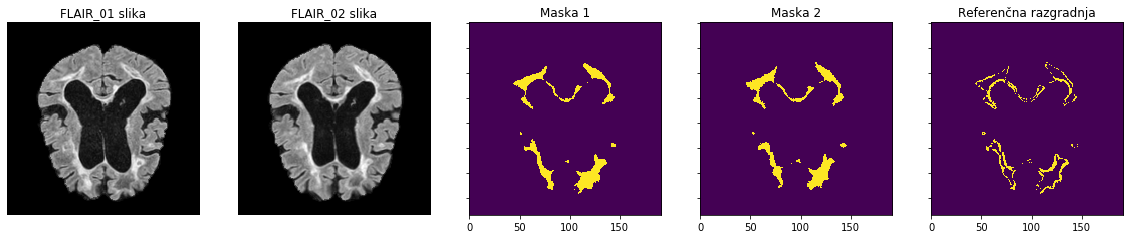

In [7]:
# Izris vzorca učnih podatkov.
viewImagesInput2d(X_train,Y0_train,Y1_train,Y01_train,MODALITIES)

In [ ]:
# NAČRTOVANJE IN UČENJE MODELA

In [8]:
# Definicija funkcije za izgradnjo U-net mreže.

# 2D U-net mreža, ki opravlja konvolucijo čez sredinsko rezino slike dimenzije NxN.
def unet2d(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    
    # vhodna plast
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    S=Lambda(lambda x: x)(inputs)
    
    C1=Conv2D(16,(3,3),activation='elu',kernel_initializer='he_normal',padding='same')(S)
    C1=Dropout(0.1)(C1)
    C1=Conv2D(16,(3,3),activation='elu',kernel_initializer='he_normal',padding='same')(C1)
    
    P1=MaxPooling2D((2,2))(C1)
    C2=Conv2D(32,(3,3),activation='elu',kernel_initializer='he_normal',padding='same')(P1)
    C2=Dropout(0.1)(C2)
    C2=Conv2D(32,(3,3),activation='elu',kernel_initializer='he_normal',padding='same')(C2)
    
    P2=MaxPooling2D((2,2))(C2)
    C3=Conv2D(64,(3,3),activation='elu',kernel_initializer='he_normal',padding='same')(P2)
    C3=Dropout(0.2)(C3)
    C3=Conv2D(64,(3,3),activation='elu',kernel_initializer='he_normal',padding='same')(C3)
    
    P3=MaxPooling2D((2,2))(C3)
    C4=Conv2D(128,(3,3),activation='elu',kernel_initializer='he_normal',padding='same')(P3)
    C4=Dropout(0.2)(C4)
    C4=Conv2D(128,(3,3),activation='elu',kernel_initializer='he_normal',padding='same')(C4)
    
    P4=MaxPooling2D((2,2))(C4)
    C5=Conv2D(256,(3,3),activation='elu',kernel_initializer='he_normal',padding='same')(P4)
    C5=Dropout(0.3)(C5)
    C5=Conv2D(256,(3,3),activation='elu',kernel_initializer='he_normal',padding='same')(C5)
    
    U6=Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(C5) # Izvedba nadvzorčenja.
    U6=concatenate([U6,C4]) # Združitev dveh plasti.
    C6=Conv2D(128,(3,3),activation='elu',kernel_initializer='he_normal',padding='same')(U6)
    C6=Dropout(0.2)(C6)
    C6=Conv2D(128,(3,3),activation='elu',kernel_initializer='he_normal',padding='same')(C6)
    
    U7=Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(C6)
    U7=concatenate([U7,C3])
    C7=Conv2D(64,(3,3),activation='elu',kernel_initializer='he_normal',padding='same')(U7)
    C7=Dropout(0.2)(C7)
    C7=Conv2D(64,(3,3),activation='elu',kernel_initializer='he_normal',padding='same')(C7)
    
    U8=Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(C7)
    U8=concatenate([U8,C2])
    C8=Conv2D(32,(3,3),activation='elu',kernel_initializer='he_normal',padding='same')(U8)
    C8=Dropout(0.1)(C8)
    C8=Conv2D(64,(3,3),activation='elu',kernel_initializer='he_normal',padding='same')(C8)
    
    U9=Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(C8)
    U9=concatenate([U9,C1])
    C9=Conv2D(16,(3,3),activation='elu',kernel_initializer='he_normal',padding='same')(U9)
    C9=Dropout(0.1)(C9)
    C9=Conv2D(16,(3,3),activation='elu',kernel_initializer='he_normal',padding='same')(C9)
    
    outputs=Conv2D(1,(1,1),activation='sigmoid')(C9)
    model=Model(inputs=[inputs],outputs=[outputs])
    
    # povzetek modela
    model.summary()
    
    return model

In [9]:
# Definicija kriterijskih funkcij

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def iou_coef(y_true, y_pred, smooth=1):
    """
    IoU = (|X &amp; Y|)/ (|X or Y|)
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    return (intersection + smooth) / ( union + smooth)

def iou_coef_loss(y_true, y_pred):
    return -iou_coef(y_true, y_pred)

def dice_coef(y_true, y_pred):
    """
    DSC = (2*|X &amp; Y|)/ (|X| + |Y|)
    """    
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

# OPOMBA: zgornje kriterijske funkcije se med učenjem izračunavajo le z namenom prikaza in niso uporabljene za samo učenje.

def weighted_cross_entropy(y_true, y_pred):
    # OPOMBA: prirejeno po https://lars76.github.io/neural-networks/object-detection/losses-for-segmentation/.
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    # beta=K.sum(y_true==0)/K.sum(y_true==1) # izračun iz deleža enic in ničel v podatkih.
    BETA=3 # ročno določeno
    # OPOMBA: s povečanjem beta zmanjšamo delež FN, z zmanjšanjem beta pa zmanjšamo delež FP.
    
    y_pred_f=K.clip(y_pred_f, K.epsilon(), 1 - K.epsilon())
    y_pred_f=K.log(y_pred_f / (1 - y_pred_f))
    
    WCE = tf.nn.weighted_cross_entropy_with_logits(logits=y_pred_f, targets=y_true_f, pos_weight=BETA)
        
    # or reduce_sum and/or axis=-1
    return K.mean(WCE)

In [11]:
# Izgradnja modela.
model=unet2d(IMG_HEIGHT, IMG_WIDTH, len(MODALITIES))

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 192, 192, 2)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 192, 192, 2)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 192, 192, 16) 304         lambda_2[0][0]                   
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 192, 192, 16) 0           conv2d_20[0][0]                  
____________________________________________________________________________________________

In [ ]:
# Prevajanje modela v strojno kodo.
model.compile(optimizer=keras.optimizers.Adam(lr=LEARNING_RATE), loss=keras.losses.binary_crossentropy, metrics=[dice_coef])
# OPOMBA: druge optimizacijske metode: Adadelta, RMSprop, SGD,...
# OPOMBA: ker je število vokslov, ki pripadajo kategoriji lezij, majhno, bi bilo dobro razreda uravnotežiti z nastavitvijo parametra class_weights. Vendar parameter ni uporaben v primeru
# večdimenzionalnih vhodov, pri nastavitvi alternativnega parametra samples_weights pa je izhod potrebno pretvoriti v 1D časovno zaporedje, kar je nepraktično.

# Uporaba lastne funkcije za izračunavanje utežene binarne križne entropije.
# model.compile(optimizer=keras.optimizers.Adam(lr=LEARNING_RATE), loss=weighted_cross_entropy, metrics=[dice_coef])

In [ ]:
# Zagon učenja modela.
earlystopper = EarlyStopping(monitor='loss',patience=5, verbose=1)
checkpointer = ModelCheckpoint(os.path.join(MODELS_PATH, MODEL_NAME), monitor='loss', verbose=1, save_best_only=True)
model.fit(X_train, Y01_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, verbose=1, validation_data=(X_test, Y01_test), callbacks=[earlystopper, checkpointer])
# OPOMBA: model ima manj parametrov kot sekvenčni model za razvrščanje, vendar vzame več časa za izračun posameznih epoh.
# OPOMBA: pri večkratnem zaporednem zagonu učenja s funkcijo fit() se uteži ne generirajo vsakič znova, ampak se učenje začne z njihovimi trenutno naučenimi vrednostmi. Tudi klic funkcije compile()
# ne resetira uteži.
# OPOMBA: ko tekom učenja uteži dobijo optimalne vrednosti, se ob ponavljanju učenja rezultat izboljšuje le še na učni zbirki, na katero se uteži vedno bolje prilegajo, ne pa več na testni zbirki.
# OPOMBA: model unet2d je nagnjen k temu, da na začetku daje veliko FN rezultatov. S ponavljanjem učenja se pristranskost manjša in načeloma ni treba uporabljati uteženih kriterijskih funkcij.

In [ ]:
# 4. VREDNOTENJE RAZGRADNJE

In [12]:
# Definicija funkcij za kvalitativno vrednotenje rezultatov.

def viewImagesOutput2d(X, Y01, preds_t, Y0, Y1, preds_m, MODALITIES):
    ix = random.randint(0, len(preds_t)-1)
    # OPOMBA: v funkcijo dodana vrednost -1, sicer lahko pri izbiranju slik z indeksom za 1 prekoračimo nabor možnih slik.
    _, _, num_modalities = X[ix].shape

    titles = [m.upper() + ' slika' for m in MODALITIES] + ['M2-M1 (ref)', 'M2-M1 (U-net)', 'M1 (ref)','M2 (ref)', 'M2 (U-Net)']
    f, ax = plt.subplots(1, num_modalities+5, sharex=True, sharey=True, figsize=(20, 5))
    for i in range(num_modalities):
        ax[i].imshow(X[ix][:,:,i].astype('float32'), cmap='gray')
        ax[i].set_title(titles[i])
        ax[i].axis('off')
    # prikaži izhodiščni maski
    ax[-5].imshow(np.squeeze(Y01[ix].astype('float32')))
    ax[-5].set_title(titles[-5])
    ax[-5].axis('off')
    ax[-4].imshow(np.squeeze(preds_t[ix].astype('float32')))
    ax[-4].set_title(titles[-4])
    ax[-4].axis('off')  
    # prikaži referenčno razgradnjo
    ax[-3].imshow(np.squeeze(Y0[ix].astype('float32')))
    ax[-3].set_title(titles[-3])
    ax[-3].axis('off')
    ax[-2].imshow(np.squeeze(Y1[ix].astype('float32')))
    ax[-2].set_title(titles[-2])
    ax[-2].axis('off')
    # prikaži razgradnjo z U-net
    ax[-1].imshow(np.squeeze(preds_m[ix]))
    ax[-1].set_title(titles[-1])
    ax[-1].axis('off')
    # OPOMBA: pretvorbo v format float32 pri prikazovanju opravimo, ker imshow ne podpira formata float16.
    
def viewImagesOutputMS2d(X, Y, preds_t, MODALITIES):
    Y=Y.astype('int')
    preds_t=preds_t.astype('int')
    ix = random.randint(0, len(preds_t)-1)
    # OPOMBA: v funkcijo dodana vrednost -1, sicer lahko pri izbiranju slik z indeksom za 1 prekoračimo nabor možnih slik.
    _, _, num_modalities = X[ix].shape

    titles = [m.upper() + ' slika' for m in MODALITIES] + ['Referenčna klasifikacija', 'Klasifikacija z U-net']
    f, ax = plt.subplots(1, num_modalities+2, sharex=True, sharey=True, figsize=(20, 5))
    for i in range(num_modalities):
        ax[i].imshow(X[ix][:,:,i].astype('float32'), cmap='gray')
        ax[i].set_title(titles[i])
        ax[i].axis('off')
    Yplot=np.ones((X.shape[1],X.shape[2]))
    Yplot[:,0]=0
    Yplot[:,-1]=0
    Yplot[0,:]=0
    Yplot[-1,:]=0
    # prikaži referenčno klasifikacijo
    ax[-2].imshow(Yplot)
    if Y[ix]==1:
        ax[-2].text(Yplot.shape[1]/2,Yplot.shape[0]/2,'MS aktivna',size=20,ha='center',va='center')
    else:
        ax[-2].text(Yplot.shape[1]/2,Yplot.shape[0]/2,'MS neaktivna',size=20,ha='center',va='center')
    ax[-2].set_title(titles[-2])
    ax[-2].axis('off')
    # prikaži klasifikacijo s CNN
    ax[-1].imshow(Yplot)
    if preds_t[ix]==1:
        ax[-1].text(Yplot.shape[1]/2,Yplot.shape[0]/2,'MS aktivna',size=20,ha='center',va='center')
    else:
        ax[-1].text(Yplot.shape[1]/2,Yplot.shape[0]/2,'MS neaktivna',size=20,ha='center',va='center')
    ax[-1].set_title(titles[-1])
    ax[-1].axis('off')
    if not(bool(preds_t[ix])^bool(Y[ix]))==1:
        print('Klasifikacija je pravilna.')
    else:
        print('Klasifikacija je nepravilna.')
    # OPOMBA: pretvorbo v format float32 pri prikazovanju opravimo, ker imshow ne podpira formata float16.

In [13]:
# Definicija funkcij za kvantitativno vrednotenje.

def dice(result, reference):
    result = np.atleast_1d(result.astype(np.bool))
    reference = np.atleast_1d(reference.astype(np.bool))
    intersection = np.count_nonzero(result & reference)
    size_i1 = np.count_nonzero(result)
    size_i2 = np.count_nonzero(reference)

    try:
        dc = 2. * intersection / float(size_i1 + size_i2)
    except ZeroDivisionError:
        dc = 0.0
    return dc

def analysisBoxplots(Title, iPos, iNeg, LABELS, DRAW=False):

    PVAL_THRESHOLD = 0.05
    # _, pval = ttest_ind(iPos, iNeg)    
    _, pval = mannwhitneyu(iPos, iNeg)
    sig = ('Not Significant','Significant')[int(pval < PVAL_THRESHOLD)]
    if DRAW==True:
        plt.figure(figsize=(5,5))
    plt.boxplot([iPos, iNeg],labels=LABELS)
    plt.title(
        '{bname}, pval={pval:.2f} ({sig})'.format(
            bname=Title,
            pval=pval,
            sig=sig
        )
    )

# Definicija funkcije za vrednotenje vpliva praga na Diceov koeficient.
def kThresholdDice(preds_train,Y_train,preds_test,Y_test):
    ktrain_dice=[]
    ktest_dice=[]
    kT=np.linspace(0,1,101)
    for k in range(kT.size):
        kpreds_train_t = (preds_train > kT[k]).astype(np.uint8)
        kpreds_test_t = (preds_test > kT[k]).astype(np.uint8)
        itrain_dice=[]
        itest_dice=[]
        for i in range(kpreds_train_t.shape[0]):
            itrain_dice.append(dice(kpreds_train_t[i].flatten(), Y_train[i].flatten()))
        for i in range(kpreds_test_t.shape[0]):
            itest_dice.append(dice(kpreds_test_t[i].flatten(), Y_test[i].flatten()))
        ktrain_dice.append(np.mean(itrain_dice))
        ktest_dice.append(np.mean(itest_dice))
    
    plt.figure(figsize=(5,5))
    plt.plot(kT,ktrain_dice,label='Train')
    plt.plot(kT,ktest_dice,label='Test')
    plt.legend()
    plt.title('Diceov koeficient v odvisnosti od vrednosti praga.')
    plt.xlabel('Threshold')
    plt.ylabel('Dice coefficient')
    plt.grid('on')
    
    return kT, ktrain_dice, ktest_dice

# Definicija funkcije za vrednotenje vpliva praga na Diceov koeficient.
# OPOMBA: funkcija opravi dodatno rekonstrukcijo maske M2 na podlagi maske M1 in maske razlik M1-M2.
def kThresholdDiceM2(preds_train,Y0_train,Y1_train,preds_test,Y0_test,Y1_test):
    ktrain_dice=[]
    ktest_dice=[]
    kT=np.linspace(0,1,101)
    for k in range(kT.size):
        kpreds_train_t01 = (preds_train > kT[k]).astype(np.uint8)
        kpreds_test_t01 = (preds_test > kT[k]).astype(np.uint8)
        kpreds_train_t=(kpreds_train_t01!=Y0_train).astype(np.uint8)
        kpreds_test_t=(kpreds_test_t01!=Y0_test).astype(np.uint8)
        itrain_dice=[]
        itest_dice=[]
        for i in range(kpreds_train_t.shape[0]):
            itrain_dice.append(dice(kpreds_train_t[i].flatten(), Y1_train[i].flatten()))
        for i in range(kpreds_test_t.shape[0]):
            itest_dice.append(dice(kpreds_test_t[i].flatten(), Y1_test[i].flatten()))
        ktrain_dice.append(np.mean(itrain_dice))
        ktest_dice.append(np.mean(itest_dice))
    
    plt.figure(figsize=(5,5))
    plt.plot(kT,ktrain_dice,label='Train')
    plt.plot(kT,ktest_dice,label='Test')
    plt.legend()
    plt.title('Diceov koeficient v odvisnosti od vrednosti praga.')
    plt.xlabel('Threshold')
    plt.ylabel('Dice coefficient')
    plt.grid('on')
    
    return kT, ktrain_dice, ktest_dice

# Definicija funkcije za vrednotenje vpliva praga na točnost.
# OPOMBA: funkcija opravi dodatno rekonstrukcijo maske M2 na podlagi maske M1 in maske razlik M1-M2.
def kThresholdACC(preds_train,Y0_train,Vs1_train,Y_train,preds_test,Y0_test,Vs1_test,Y_test,dv_threshold_2d):
    ktrain_ACC=[]
    ktest_ACC=[]
    kT=np.linspace(0,1,101)
    for k in range(kT.size):
        # Binarizacija maske razlik M1-M2 glede na trenutni prag.
        kpreds_train_t01 = (preds_train > kT[k]).astype(np.uint8)
        kpreds_test_t01 = (preds_test > kT[k]).astype(np.uint8)
        # Izračun maske M2 iz mask M1 in M1-M2.
        kpreds_train_t=(kpreds_train_t01!=Y0_train).astype(np.uint8)
        kpreds_test_t=(kpreds_test_t01!=Y0_test).astype(np.uint8)
        # Izračun volumna maske M2p.
        kVs2p_train=np.sum(np.sum((np.squeeze(kpreds_train_t)==1),axis=-1),axis=-1)/100 # Pretvorba iz mm**2 v cm**2.
        kVs2p_test=np.sum(np.sum((np.squeeze(kpreds_test_t)==1),axis=-1),axis=-1)/100 # Pretvorba iz mm**2 v cm**2.
        # Izračun razlike volumnov mask M2p-M1.
        kdVs2p1r_train=kVs2p_train-Vs1_train # Podano v cm**2.
        kdVs2p1r_test=kVs2p_test-Vs1_test # Podano v cm**2.
        # Izračun klasifikacije z binarizacijo spremembe volumna mask M2p-M1.
        kpredsdv_train = (kdVs2p1r_train > dv_threshold_2d).astype(np.uint8)
        kpredsdv_test = (kdVs2p1r_test > dv_threshold_2d).astype(np.uint8)
        # Izračun točnosti.
        kACC_train,_,_=Metrics(kpredsdv_train,Y_train)
        kACC_test,_,_=Metrics(kpredsdv_test,Y_test)
        ktrain_ACC.append(kACC_train)
        ktest_ACC.append(kACC_test)
    
    plt.figure(figsize=(5,5))
    plt.plot(kT,ktrain_ACC,label='Train')
    plt.plot(kT,ktest_ACC,label='Test')
    plt.legend()
    plt.title('Točnost v odvisnosti od vrednosti praga.')
    plt.xlabel('Threshold')
    plt.ylabel('ACC')
    plt.grid('on')
    
    return kT, ktrain_ACC, ktest_ACC
    
def Metrics(preds_t,Y):
    TN=np.count_nonzero((preds_t==0)&(Y==0))
    FN=np.count_nonzero((preds_t==0)&(Y==1))
    FP=np.count_nonzero((preds_t==1)&(Y==0))
    TP=np.count_nonzero((preds_t==1)&(Y==1))
    
    # Točnost.
    ACC=(TN+TP)/(TN+FN+FP+TP)
    # Občutljivost.
    TPR=TP/(FN+TP)
    # Specifičnost.
    TNR=TN/(TN+FP)
    
    return ACC, TPR, TNR
    
def analysisROC(Title, iPos, iNeg, DRAW=False):

    p = int((sum(iPos)/len(iPos)) > (sum(iNeg)/len(iNeg)))

    fpr, tpr, thrs = roc_curve([p] * len(iPos) + [1-p] * len(iNeg), iPos + iNeg)
    roc_auc = auc(fpr, tpr)

    if DRAW==True:
        plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{bname}, ROC (AUC={auc:.2f})'.format(bname=Title.upper(),auc=roc_auc))
    plt.legend(loc="lower right")

In [15]:
# Nalaganje modela in izračun razgradnje na učni in testni zbirki.

# Nalaganje modela.
model = load_model(os.path.join(MODELS_PATH, MODEL_NAME), custom_objects={'dice_coef': dice_coef, 'dice_coef_loss': dice_coef_loss})

# OPOMBA: pri nalaganju modela, ki smo ga ustvarili v Google Colab, dobimo drugačne rezultate vrednotenje, kot če isti model testiramo v Google Colab. Pri obratni poti (testiranje modela,
# ustvarjenega v JupyterLab, v Google Colab) pa modela niti ne moremo naložiti. Razlog je v različnih nameščenih verzijah paketa Keras, ki pri istih klicanih parametrih uporablja v ozadju
# različne algoritme učenja in klicanja funkcij, kar povzroča nekompatibilnost pri uporabi istih modelov v različnih okoljih.

# OPOMBA: nalaganje modela v primeru uporabe lastne izgubne kriterijske funkcije weighted_cross_entropy.
# model = load_model(os.path.join(MODELS_PATH, MODEL_NAME), custom_objects={'dice_coef': dice_coef, 'dice_coef_loss': dice_coef_loss, 'weighted_cross_entropy': weighted_cross_entropy})

# Primerjava vrednosti kriterijskih funkcij med učno in testno zbirko.
print('Metrike modela:',model.metrics_names)
print('')
score = model.evaluate(X_train, Y01_train, verbose=0)
print('Učna zbirka')
print('\tloss:', score[0])
print('\tdice_coef:', score[1])
score = model.evaluate(X_test, Y01_test, verbose=0)
print('Testna zbirka')
print('\tloss:', score[0])
print('\tdice_coef:', score[1])

Metrike modela: ['loss', 'dice_coef']

Učna zbirka
	loss: 0.0051543502038163425
	dice_coef: 0.5708460807800293
Testna zbirka
	loss: 0.01715332828462124
	dice_coef: 0.228033185005188


In [16]:
# Razgradnja na učni in testni zbirki.
preds_train = model.predict(X_train, verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Binarizacija vrednosti.
preds_train_t01 = (preds_train > THRESHOLD).astype(np.uint8)
preds_test_t01 = (preds_test > THRESHOLD).astype(np.uint8)

# Rekonstrukcija maske M2.
preds_train_t=(preds_train_t01!=Y0_train)
preds_test_t=(preds_test_t01!=Y0_test)

49/49 [==============================] - ETA:  - 1s 31ms/step


In [ ]:
# VREDNOTENJE RAZGRADNJE

In [17]:
# Preverba števila pikslov, pripadajočih lezijam.
print('Število pikslov v referenčni maski razlik:',np.sum(Y01_train.astype('uint8')))
print('Število pikslov v izračunani maski razlik:',np.sum(preds_train_t.astype('uint8')))
# OPOMBA: preverba, ali dobimo pretirano število FP oz. FN pikslov.

Število pikslov v referenčni maski razlik: 15814
Število pikslov v izračunani maski razlik: 37017


Indeks optimalnega aktivacijskega praga na učni zbirki: 46
Vrednost optimalnega aktivacijskega praga na učni zbirki: 0.46
Optimalni Diceov koeficient na učni zbirki: 0.6896338874826284
Diceov koeficient na testni zbirki pri optimalnem aktivacijskem pragu na učni zbirki: 0.18152539382820584



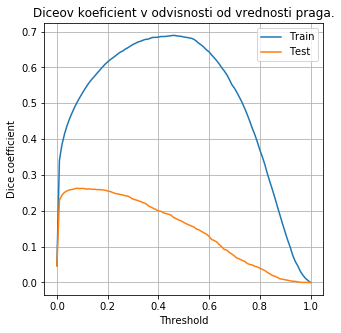

In [18]:
# Preverba vpliva praga THRESHOLD na Diceov koeficient med maskama M2p-M1 in maskama M2-M1.

kT_dice_delta, ktrain_dice_delta, ktest_dice_delta = kThresholdDice(preds_train,Y01_train,preds_test,Y01_test)

print('Indeks optimalnega aktivacijskega praga na učni zbirki:',np.argmax(ktrain_dice_delta))
print('Vrednost optimalnega aktivacijskega praga na učni zbirki:', kT_dice_delta[np.argmax(ktrain_dice_delta)])
print('Optimalni Diceov koeficient na učni zbirki:',ktrain_dice_delta[np.argmax(ktrain_dice_delta)])
print('Diceov koeficient na testni zbirki pri optimalnem aktivacijskem pragu na učni zbirki:',ktest_dice_delta[np.argmax(ktrain_dice_delta)])
print('')
# OPOMBA: preverba, pri kateri vrednosti aktivacijskega praga na učni zbirki dobimo najvišjo vrednost Diceovega koeficienta (ni nujno vedno pri 0.5).

Indeks optimalnega aktivacijskega praga na učni zbirki: 54
Vrednost optimalnega aktivacijskega praga na učni zbirki: 0.54
Optimalni Diceov koeficient na učni zbirki: 0.8424685517210504
Diceov koeficient na testni zbirki pri optimalnem aktivacijskem pragu na učni zbirki: 0.6368978219703032



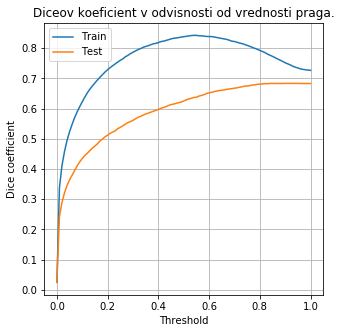

In [19]:
# Preverba vpliva praga THRESHOLD na Diceov koeficient med maskama M2p in M2.

kT_dice, ktrain_dice, ktest_dice = kThresholdDiceM2(preds_train,Y0_train,Y1_train,preds_test,Y0_test,Y1_test)

print('Indeks optimalnega aktivacijskega praga na učni zbirki:',np.argmax(ktrain_dice))
print('Vrednost optimalnega aktivacijskega praga na učni zbirki:', kT_dice[np.argmax(ktrain_dice)])
print('Optimalni Diceov koeficient na učni zbirki:',ktrain_dice[np.argmax(ktrain_dice)])
print('Diceov koeficient na testni zbirki pri optimalnem aktivacijskem pragu na učni zbirki:',ktest_dice[np.argmax(ktrain_dice)])
print('')
# OPOMBA: preverba, pri kateri vrednosti aktivacijskega praga na učni zbirki dobimo najvišjo vrednost Diceovega koeficienta (ni nujno vedno pri 0.5).

In [ ]:
# Učna zbirka.

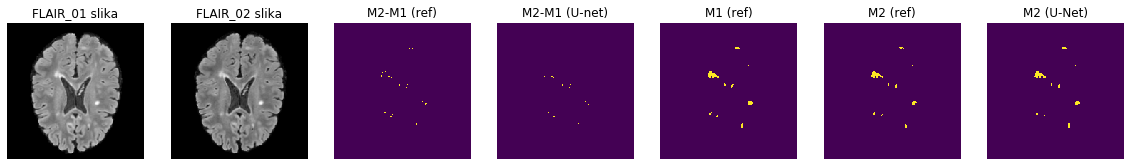

In [20]:
# Kvalitativno: kakovost razgradnje na učnih vzorcih (ali sploh deluje?)

# Preverjanje kakovosti razgradnje na učnih vzorcih (sanity check).
viewImagesOutput2d(X_train, Y01_train, preds_train_t01, Y0_train, Y1_train, preds_train_t, MODALITIES)

In [21]:
# Kvantitativno: izračun Diceovih koeficientov na učnih slikah.

train_dice_delta=[]
train_dice1r2r=[]
train_dice1r2p=[]
train_dice2p2r=[]
for i in range(preds_train_t.shape[0]):
    # Diceov kofiecient na izračunani razliki mask in referenčni razliki.
    train_dice_delta.append(dice(preds_train_t01[i].flatten(),Y01_train[i].flatten()))
    # Diceov koeficient na prvi maski in referenčni drugi maski.
    train_dice1r2r.append(dice(Y0_train[i].flatten(),Y1_train[i].flatten()))
    # Diceov koeficient na prvi maski in izračunani drugi maski.
    train_dice1r2p.append(dice(Y0_train[i].flatten(),preds_train_t[i].flatten()))
    # Diceov koeficient na izračunani drugi maski in referenčni drugi maski.
    train_dice2p2r.append(dice(preds_train_t[i].flatten(), Y1_train[i].flatten()))

Povprečna vrednost Diceovega koeficienta M1M2p-M1M2 na učni zbirki: 0.685024098766782

Povprečna vrednost Diceovega koeficienta M1-M2 na učni zbirki:  0.7266561328316568
Povprečna vrednost Diceovega koeficienta M1-M2p na učni zbirki:  0.7386402736002231
Povprečna vrednost Diceovega koeficienta M2p-M2 na učni zbirki:  0.8379502416420946



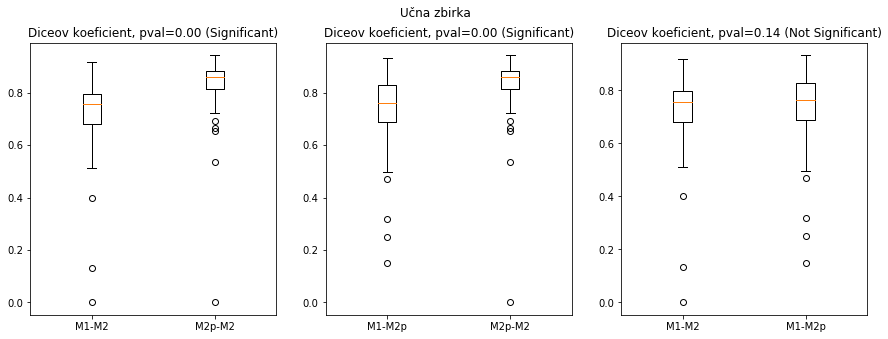

In [22]:
# Statistična primerjava Diceovih koeficientov na učnih slikah.

print('Povprečna vrednost Diceovega koeficienta M1M2p-M1M2 na učni zbirki:', np.mean(train_dice_delta))
print('')
print('Povprečna vrednost Diceovega koeficienta M1-M2 na učni zbirki: ', np.mean(train_dice1r2r))
print('Povprečna vrednost Diceovega koeficienta M1-M2p na učni zbirki: ', np.mean(train_dice1r2p))
print('Povprečna vrednost Diceovega koeficienta M2p-M2 na učni zbirki: ', np.mean(train_dice2p2r))
print('')
# OPOMBA: preverba, kako dobro se izračunana maska M2p ujema z maskama M1 in M2. Vrednosti nam povedo, ali se M2p po podobnosti nahaja stran od M1, stran od M2 ali vmes med M1 in M2.
# OPOMBA: primerjavo z masko M1 opravljamo za preverbo morebitne prevelike prilagoditve M2p maski M1, kar se lahko zgodi, če je maska M1 dana na vhod mreže pri učenju.

plt.figure(figsize=(15,5))
plt.suptitle('Učna zbirka')
plt.subplot(1,3,1)
analysisBoxplots('Diceov koeficient', train_dice1r2r, train_dice2p2r, LABELS=['M1-M2','M2p-M2'])
# OPOMBA: uporabljen Mann-Whitneyjev neparametrični statistični test.
# OPOMBA: pri optimalni razgradnji pričakujemo večje ujemanje M2 z M2p kot z M1.
plt.subplot(1,3,2)
analysisBoxplots('Diceov koeficient', train_dice1r2p, train_dice2p2r, LABELS=['M1-M2p','M2p-M2'])
# OPOMBA: uporabljen Mann-Whitneyjev neparametrični statistični test.
# OPOMBA: pri optimalni razgradnji pričakujemo večje ujemanje M2p z M2 kot z M1.
plt.subplot(1,3,3)
analysisBoxplots('Diceov koeficient', train_dice1r2r, train_dice1r2p, LABELS=['M1-M2','M1-M2p'])
# OPOMBA: uporabljen Mann-Whitneyjev neparametrični statistični test.
# OPOMBA: pri optimalni razgradnji pričakujemo enako ujemanje M1 z M2p kot z M2.

In [23]:
# Volumen maske M2p.
Vs2p_train=np.sum(np.sum((np.squeeze(preds_train_t)==1),axis=-1),axis=-1)/100 # Pretvorba iz mm**2 v cm**2.

# Razlika M2-M1.
dVs2r1r_train=Vs2_train-Vs1_train # Podano v cm**2.
# Razlika M2p-M1
dVs2p1r_train=Vs2p_train-Vs1_train # Podano v cm**2.
# Razlika M2-M2p.
dVs2p2r_train=Vs2p_train-Vs2_train # Podano v cm**2.

# OPOMBA: razliko M2p-M2 izračunamo tako, da dobimo pozitivno povprečno vrednost.

Povprečna vrednost volumna M1 na učni zbirki:  3.0889380530973454
Povprečna vrednost volumna M2 na učni zbirki:  3.1390265486725664
Povprečna vrednost volumna M2p na učni zbirki:  3.2758407079646017



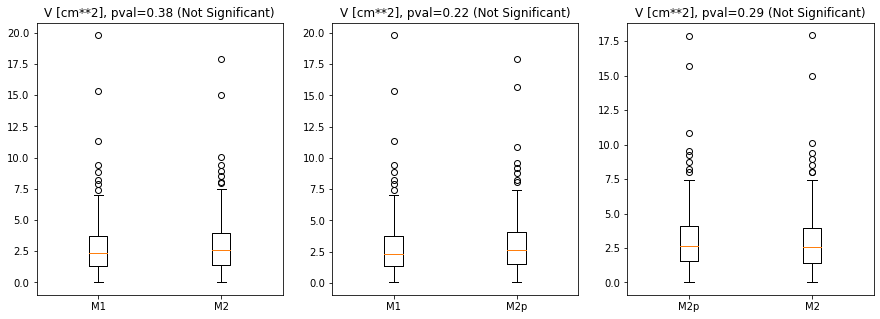

In [24]:
# Statistični test (volumni).

print('Povprečna vrednost volumna M1 na učni zbirki: ', np.mean(Vs1_train))
print('Povprečna vrednost volumna M2 na učni zbirki: ', np.mean(Vs2_train))
print('Povprečna vrednost volumna M2p na učni zbirki: ', np.mean(Vs2p_train))
print('')
# OPOMBA: preverba, kako dobro se volumen izračunane maske M2p ujema z volumnoma mask M1 in M2. Vrednosti nam povedo, ali se volumen M2p nahaja stran od M1, stran od M2 ali vmes M1 in M2.

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
analysisBoxplots('V [cm**2]',Vs1_train,Vs2_train,['M1','M2'])
# OPOMBA: uporabljen Mann-Whitneyjev neparametrični statistični test.
plt.subplot(1,3,2)
analysisBoxplots('V [cm**2]',Vs1_train,Vs2p_train,['M1','M2p'])
# OPOMBA: uporabljen Mann-Whitneyjev neparametrični statistični test.
plt.subplot(1,3,3)
analysisBoxplots('V [cm**2]',Vs2p_train,Vs2_train,['M2p','M2'])
# OPOMBA: uporabljen Mann-Whitneyjev neparametrični statistični test.

# OPOMBA: preverba, koliko so se že absolutni volumni mask M1, M2 in M2p med seboj statistično pomembno razlikujejo.

Povprečna sprememba volumna M2-M1 na učni zbirki:  0.05008849557522122
Povprečna sprememba volumna M2p-M1 na učni zbirki:  0.18690265486725666
Povprečna sprememba volumna M2-M2p na učni zbirki:  0.13681415929203541



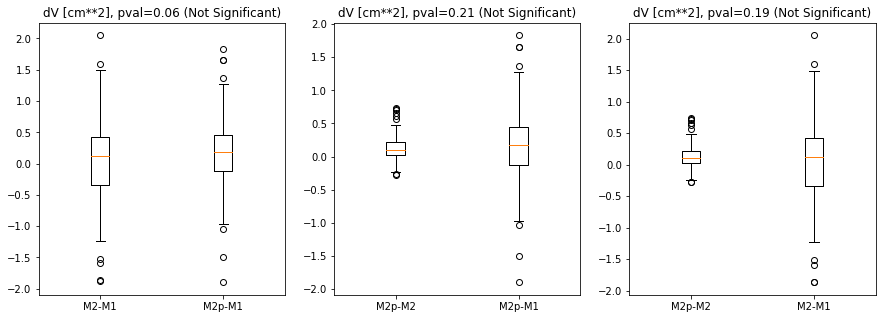

In [25]:
# Statistični test (spremembe volumnov).

print('Povprečna sprememba volumna M2-M1 na učni zbirki: ', np.mean(dVs2r1r_train))
print('Povprečna sprememba volumna M2p-M1 na učni zbirki: ', np.mean(dVs2p1r_train))
print('Povprečna sprememba volumna M2-M2p na učni zbirki: ', np.mean(dVs2p2r_train))
print('')
# OPOMBA: primerjavo z masko M1 opravljamo za preverbo morebitne prevelike prilagoditve M2p maski M1, kar se lahko zgodi, če je maska M1 dana na vhod mreže pri učenju.

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
analysisBoxplots('dV [cm**2]',dVs2r1r_train,dVs2p1r_train,['M2-M1','M2p-M1'])
# OPOMBA: uporabljen Mann-Whitneyjev neparametrični statistični test.
# OPOMBA: pri optimalni razgradnji pričakujemo enaki razliki med M2 in M1 ter M2p in M1.
plt.subplot(1,3,2)
analysisBoxplots('dV [cm**2]',dVs2p2r_train,dVs2p1r_train,['M2p-M2','M2p-M1'])
# OPOMBA: uporabljen Mann-Whitneyjev neparametrični statistični test.
# OPOMBA: pri optimalni razgradnji pričakujemo manjšo razliko med M2p in M2 kot med M2p in M1.
plt.subplot(1,3,3)
analysisBoxplots('dV [cm**2]',dVs2p2r_train,dVs2r1r_train,['M2p-M2','M2-M1'])
# OPOMBA: uporabljen Mann-Whitneyjev neparametrični statistični test.
# OPOMBA: pri optimalni razgradnji pričakujemo manjšo razliko med M2 in M2p kot med M2 in M1.

# OPOMBA: ob dobrem ujemanju med M2p in M2 pričakujemo tudi manjšo varianco razlik volumnov M2p-M2.

In [ ]:
# Testna zbirka

# OPOMBA: na testni zbirki pričakujemo podobne rezultate kot na učni.

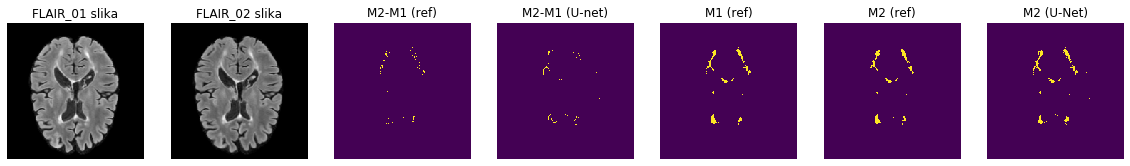

In [30]:
# Kvalitativno: kakovost razgradnje na testnih vzorcih (zmožnost posploševanja).

# Preverjanje kakovosti razgradnje na naključno izbranih testnih vzorcih.
viewImagesOutput2d(X_test, Y01_test, preds_test_t01, Y0_test, Y1_test, preds_test_t, MODALITIES)

In [31]:
# Kvantitativno: vrednosti Diceovih koeficientov na testnih slikah.

test_dice_delta=[]
test_dice1r2r=[]
test_dice1r2p=[]
test_dice2p2r=[]
for i in range(preds_test_t.shape[0]):
    # Diceov kofiecient na izračunani razliki mask in referenčni razliki.
    test_dice_delta.append(dice(preds_test_t01[i].flatten(),Y01_test[i].flatten()))
    # Diceov koeficient na prvi maski in referenčni drugi maski.
    test_dice1r2r.append(dice(Y0_test[i].flatten(),Y1_test[i].flatten()))
    # Diceov koeficient na prvi maski in izračunani drugi maski.
    test_dice1r2p.append(dice(Y0_test[i].flatten(),preds_test_t[i].flatten()))
    # Diceov koeficient na izračunani drugi maski in referenčni drugi maski.
    test_dice2p2r.append(dice(preds_test_t[i].flatten(), Y1_test[i].flatten()))

Povprečna vrednost Diceovega koeficienta M1M2p-M1M2 na testni zbirki: 0.16769824631443642

Povprečna vrednost Diceovega koeficienta M1-M2 na testni zbirki:  0.6830539827658659
Povprečna vrednost Diceovega koeficienta M1-M2p na testni zbirki:  0.816472212739546
Povprečna vrednost Diceovega koeficienta M2p-M2 na testni zbirki:  0.6251624261412139



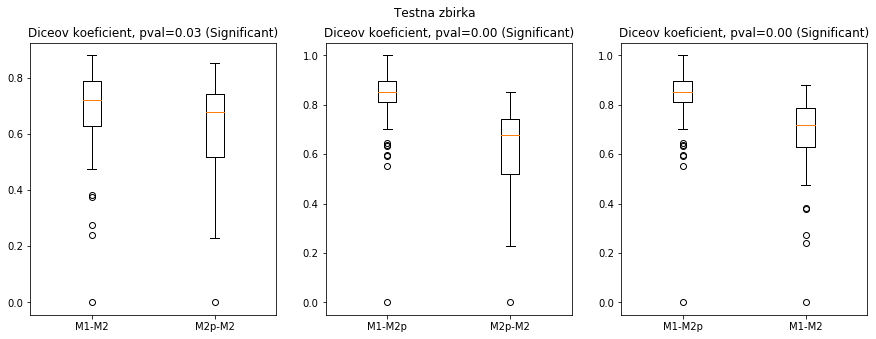

In [32]:
# Statistična primerjava Diceovih koeficientov na testnih slikah.

print('Povprečna vrednost Diceovega koeficienta M1M2p-M1M2 na testni zbirki:', np.mean(test_dice_delta))
print('')
print('Povprečna vrednost Diceovega koeficienta M1-M2 na testni zbirki: ', np.mean(test_dice1r2r))
print('Povprečna vrednost Diceovega koeficienta M1-M2p na testni zbirki: ', np.mean(test_dice1r2p))
print('Povprečna vrednost Diceovega koeficienta M2p-M2 na testni zbirki: ', np.mean(test_dice2p2r))
print('')

plt.figure(figsize=(15,5))
plt.suptitle('Testna zbirka')
plt.subplot(1,3,1)
analysisBoxplots('Diceov koeficient', test_dice1r2r, test_dice2p2r, LABELS=['M1-M2','M2p-M2'])
# OPOMBA: uporabljen Mann-Whitneyjev neparametrični statistični test
plt.subplot(1,3,2)
analysisBoxplots('Diceov koeficient', test_dice1r2p, test_dice2p2r, LABELS=['M1-M2p','M2p-M2'])
# OPOMBA: uporabljen Mann-Whitneyjev neparametrični statistični test
plt.subplot(1,3,3)
analysisBoxplots('Diceov koeficient', test_dice1r2p, test_dice1r2r, LABELS=['M1-M2p','M1-M2'])
# OPOMBA: uporabljen Mann-Whitneyjev neparametrični statistični test

In [33]:
# Volumen maske M2p.
Vs2p_test=np.sum(np.sum((np.squeeze(preds_test_t)==1),axis=-1),axis=-1)/100 # Pretvorba iz mm**2 v cm**2.

# Razlika M2-M1.
dVs2r1r_test=Vs2_test-Vs1_test # Podano v cm**2.
# Razlika M2p-M1
dVs2p1r_test=Vs2p_test-Vs1_test # Podano v cm**2.
# Razlika M2-M2p.
dVs2p2r_test=Vs2p_test-Vs2_test # Podano v cm**2.

# OPOMBA: razliko M2p-M2 izračunamo tako, da dobimo pozitivno povprečno vrednost.

Povprečna vrednost volumna M1 na testni zbirki:  2.6255102040816327
Povprečna vrednost volumna M2 na testni zbirki:  2.6273469387755104
Povprečna vrednost volumna M2p na testni zbirki:  2.8687755102040815



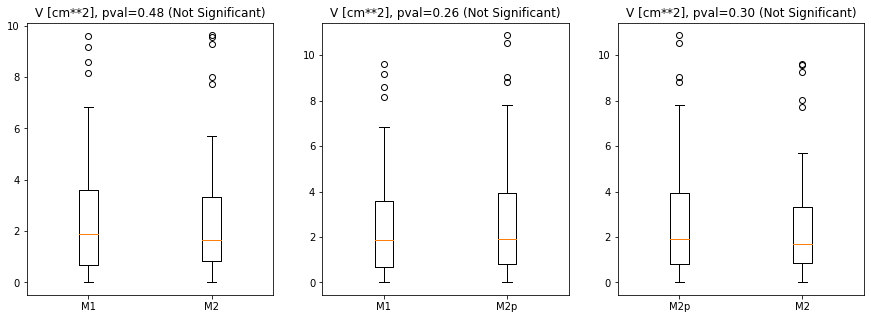

In [34]:
# Statistični test (volumni).

print('Povprečna vrednost volumna M1 na testni zbirki: ', np.mean(Vs1_test))
print('Povprečna vrednost volumna M2 na testni zbirki: ', np.mean(Vs2_test))
print('Povprečna vrednost volumna M2p na testni zbirki: ', np.mean(Vs2p_test))
print('')

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
analysisBoxplots('V [cm**2]',Vs1_test,Vs2_test,['M1','M2'])
# OPOMBA: uporabljen Mann-Whitneyjev neparametrični statistični test.
plt.subplot(1,3,2)
analysisBoxplots('V [cm**2]',Vs1_test,Vs2p_test,['M1','M2p'])
# OPOMBA: uporabljen Mann-Whitneyjev neparametrični statistični test.
plt.subplot(1,3,3)
analysisBoxplots('V [cm**2]',Vs2p_test,Vs2_test,['M2p','M2'])
# OPOMBA: uporabljen Mann-Whitneyjev neparametrični statistični test.

# OPOMBA: vidimo, da dobimo podobne rezultate kot pri učni zbirki.

Povprečna sprememba volumna M2-M1 na testni zbirki:  0.001836734693877546
Povprečna sprememba volumna M2p-M1 na testni zbirki:  0.24326530612244898
Povprečna sprememba volumna M2p-M2 na testni zbirki:  0.24142857142857138



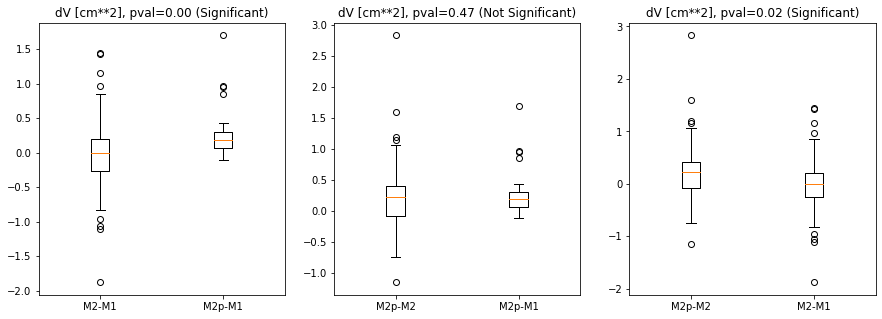

In [35]:
# Statistični test (spremembe volumnov).

print('Povprečna sprememba volumna M2-M1 na testni zbirki: ', np.mean(dVs2r1r_test))
print('Povprečna sprememba volumna M2p-M1 na testni zbirki: ', np.mean(dVs2p1r_test))
print('Povprečna sprememba volumna M2p-M2 na testni zbirki: ', np.mean(dVs2p2r_test))
print('')

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
analysisBoxplots('dV [cm**2]',dVs2r1r_test,dVs2p1r_test,['M2-M1','M2p-M1'])
# OPOMBA: uporabljen Mann-Whitneyjev neparametrični statistični test.
plt.subplot(1,3,2)
analysisBoxplots('dV [cm**2]',dVs2p2r_test,dVs2p1r_test,['M2p-M2','M2p-M1'])
# OPOMBA: uporabljen Mann-Whitneyjev neparametrični statistični test.
plt.subplot(1,3,3)
analysisBoxplots('dV [cm**2]',dVs2p2r_test,dVs2r1r_test,['M2p-M2','M2-M1'])
# OPOMBA: uporabljen Mann-Whitneyjev neparametrični statistični test.

In [ ]:
# VREDNOTENJE RAZVRŠČANJA

Indeks optimalnega aktivacijskega praga na učni zbirki: 50
Vrednost optimalnega aktivacijskega praga na učni zbirki: 0.5
Optimalna točnost na učni zbirki: 0.8938053097345132
Točnost na testni zbirki pri optimalnem aktivacijskem pragu na učni zbirki: 0.5510204081632653



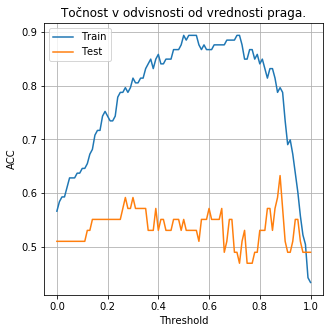

In [36]:
# Preverba vpliva praga THRESHOLD na točnost.

kT_ACC, ktrain_ACC, ktest_ACC = kThresholdACC(preds_train,Y0_train,Vs1_train,Y_train[:,1],preds_test,Y0_test,Vs1_test,Y_test[:,1],DV_THRESHOLD_2D)

print('Indeks optimalnega aktivacijskega praga na učni zbirki:',np.argmax(ktrain_ACC))
print('Vrednost optimalnega aktivacijskega praga na učni zbirki:', kT_ACC[np.argmax(ktrain_ACC)])
print('Optimalna točnost na učni zbirki:',ktrain_ACC[np.argmax(ktrain_ACC)])
print('Točnost na testni zbirki pri optimalnem aktivacijskem pragu na učni zbirki:',ktest_ACC[np.argmax(ktrain_ACC)])
print('')
# OPOMBA: preverba, pri kateri vrednosti aktivacijskega praga na učni zbirki dobimo največjo točnost (ni nujno vedno pri 0.5).

In [ ]:
# Učna zbirka

In [37]:
# Klasifikacija na podlagi maske M2p.
predsdv_train=np.zeros_like(dVs2p1r_train)
predsdv_train[dVs2p1r_train>DV_THRESHOLD_2D]=1

Klasifikacija je pravilna.


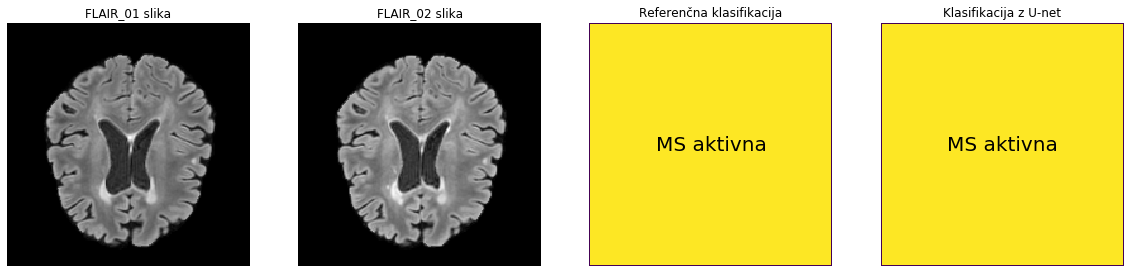

In [38]:
# Vrednotenje na posameznih slikah.

viewImagesOutputMS2d(X_train,Y_train[:,1],predsdv_train,MODALITIES)

In [39]:
# Razdelitev pacientov na tiste z aktivno MS in tiste z neaktivno MS.

Nr_train=np.count_nonzero(Y_train[:,0])
Ar_train=np.count_nonzero(Y_train[:,1])

Nr2d_train=np.count_nonzero(Y2D_train_t==0)
Ar2d_train=np.count_nonzero(Y2D_train_t==1)

Np_train=np.count_nonzero(predsdv_train==0)
Ap_train=np.count_nonzero(predsdv_train==1)

print('Referenčna klasifikacija:')
print('Število pacientov z neaktivno MS:',Nr_train)
print('Število pacientov z aktivno MS:',Ar_train)
print('')
print('Klasifikacija na podlagi sredinskih rezin referenčnih mask:')
print('Število pacientov z neaktivno MS:',Nr2d_train)
print('Število pacientov z aktivno MS:',Ar2d_train)
print('')
print('Izračunana klasifikacija:')
print('Število pacientov z neaktivno MS:',Np_train)
print('Število pacientov z aktivno MS:',Ap_train)

Referenčna klasifikacija:
Število pacientov z neaktivno MS: 49
Število pacientov z aktivno MS: 64

Klasifikacija na podlagi sredinskih rezin referenčnih mask:
Število pacientov z neaktivno MS: 51
Število pacientov z aktivno MS: 62

Izračunana klasifikacija:
Število pacientov z neaktivno MS: 43
Število pacientov z aktivno MS: 70


In [40]:
# Metrike kvalitete klasifikacije.

# Izračuni metrik.
ACCp_train,TPRp_train,TNRp_train=Metrics(predsdv_train,Y_train[:,1])

# Izpis rezultatov.
print('Rezultati razvrščanja na učnih podatkih (izračunana klasifikacija):')
print('Točnost:',ACCp_train)
print('Občutljivost:',TPRp_train)
print('Specifičnost:',TNRp_train)
print('')

# Izračuni metrik.
ACCr_train,TPRr_train,TNRr_train=Metrics(Y2D_train_t,Y_train[:,1])

print('Rezultati razvrščanja na učnih podatkih (referenčna klasifikacija):')
print('Točnost:',ACCr_train)
print('Občutljivost:',TPRr_train)
print('Specifičnost:',TNRr_train)

Rezultati razvrščanja na učnih podatkih (izračunana klasifikacija):
Točnost: 0.8938053097345132
Občutljivost: 0.953125
Specifičnost: 0.8163265306122449

Rezultati razvrščanja na učnih podatkih (referenčna klasifikacija):
Točnost: 0.9646017699115044
Občutljivost: 0.953125
Specifičnost: 0.9795918367346939


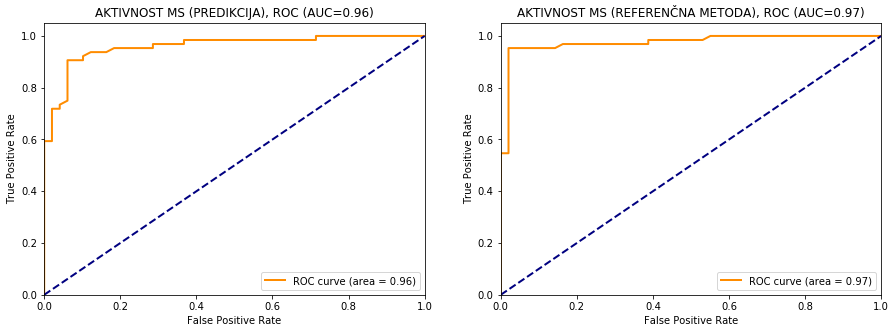

In [41]:
# Izračun ROC krivulje

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
analysisROC('Aktivnost MS (predikcija)', dVs2p1r_train[Y_train[:,1]==0].tolist(), dVs2p1r_train[Y_train[:,1]==1].tolist())
plt.subplot(1,2,2)
analysisROC('Aktivnost MS (referenčna metoda)', Y2D_train[Y_train[:,1]==0].tolist(), Y2D_train[Y_train[:,1]==1].tolist())

In [ ]:
# Testna zbirka

In [42]:
# Klasifikacija na podlagi maske M2p.
predsdv_test=np.zeros_like(dVs2p1r_test)
predsdv_test[dVs2p1r_test>DV_THRESHOLD_2D]=1

Klasifikacija je pravilna.


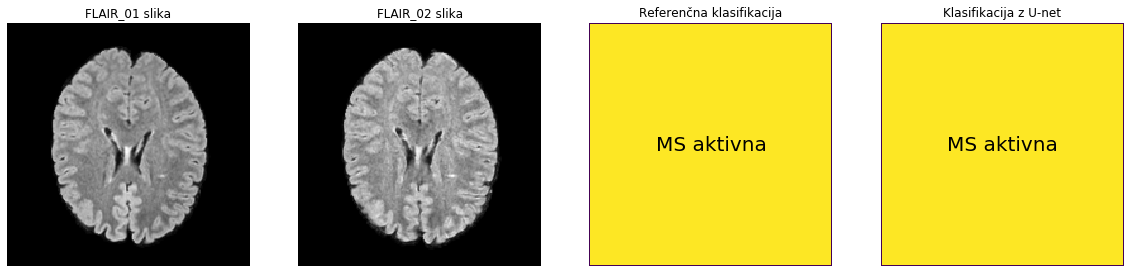

In [45]:
# Vrednotenje na posameznih slikah.

viewImagesOutputMS2d(X_test,Y_test[:,1],predsdv_test,MODALITIES)

In [46]:
# Razdelitev pacientov na tiste z aktivno MS in tiste z neaktivno MS.

Nr_test=np.count_nonzero(Y_test[:,0])
Ar_test=np.count_nonzero(Y_test[:,1])

Nr2d_test=np.count_nonzero(Y2D_test_t==0)
Ar2d_test=np.count_nonzero(Y2D_test_t==1)

Np_test=np.count_nonzero(predsdv_test==0)
Ap_test=np.count_nonzero(predsdv_test==1)

print('Referenčna klasifikacija:')
print('Število pacientov z neaktivno MS:',Nr_test)
print('Število pacientov z aktivno MS:',Ar_test)
print('')
print('Klasifikacija na podlagi sredinskih rezin referenčnih mask:')
print('Število pacientov z neaktivno MS:',Nr2d_test)
print('Število pacientov z aktivno MS:',Ar2d_test)
print('')
print('Izračunana klasifikacija:')
print('Število pacientov z neaktivno MS:',Np_test)
print('Število pacientov z aktivno MS:',Ap_test)

Referenčna klasifikacija:
Število pacientov z neaktivno MS: 24
Število pacientov z aktivno MS: 25

Klasifikacija na podlagi sredinskih rezin referenčnih mask:
Število pacientov z neaktivno MS: 25
Število pacientov z aktivno MS: 24

Izračunana klasifikacija:
Število pacientov z neaktivno MS: 6
Število pacientov z aktivno MS: 43


In [47]:
# Metrike kvalitete klasifikacije.

# Izračuni metrik.
ACCp_test,TPRp_test,TNRp_test=Metrics(predsdv_test,Y_test[:,1])

# Izpis rezultatov.
print('Rezultati razvrščanja na testnih podatkih (izračunana klasifikacija):')
print('Točnost:',ACCp_test)
print('Občutljivost:',TPRp_test)
print('Specifičnost:',TNRp_test)
print('')

# Izračuni metrik.
ACCr_test,TPRr_test,TNRr_test=Metrics(Y2D_test_t,Y_test[:,1])

print('Rezultati razvrščanja na testnih podatkih (referenčna klasifikacija):')
print('Točnost:',ACCr_test)
print('Občutljivost:',TPRr_test)
print('Specifičnost:',TNRr_test)

Rezultati razvrščanja na testnih podatkih (izračunana klasifikacija):
Točnost: 0.5510204081632653
Občutljivost: 0.92
Specifičnost: 0.16666666666666666

Rezultati razvrščanja na testnih podatkih (referenčna klasifikacija):
Točnost: 0.9387755102040817
Občutljivost: 0.92
Specifičnost: 0.9583333333333334


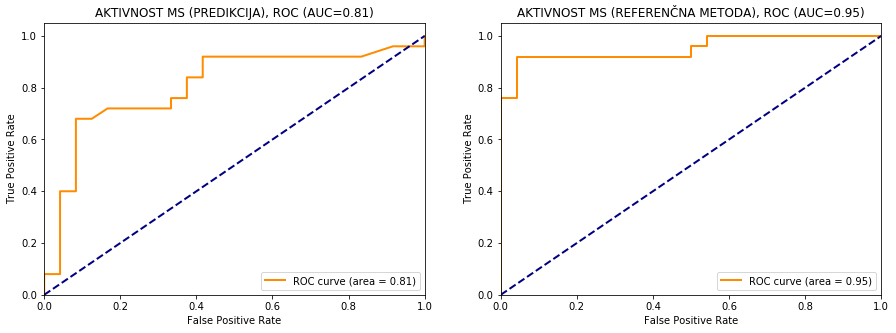

In [48]:
# Izračun ROC krivulje

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
analysisROC('Aktivnost MS (predikcija)', dVs2p1r_test[Y_test[:,1]==0].tolist(), dVs2p1r_test[Y_test[:,1]==1].tolist())
plt.subplot(1,2,2)
analysisROC('Aktivnost MS (referenčna metoda)', Y2D_test[Y_test[:,1]==0].tolist(), Y2D_test[Y_test[:,1]==1].tolist())